In [ ]:
from google.colab import drive

In [ ]:
import h5py
import numpy as np
import os
from PIL import Image
from PIL.Image import Image as Image_t
import matplotlib.pyplot as plt
import torch

from abc import ABC, abstractmethod
from typing import Type, Union


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode as IM
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
from tqdm.notebook import tqdm

In [ ]:

class storage_class(ABC):
    def __init__(self, config: dict):
        self.config = config
        self.pos = 0
        self.__locked = False

    @property
    @abstractmethod
    def dataset_size(self) -> int:
        """
        Вернуть количество пар (изображение, маска) в датасете
        """
        pass

    @abstractmethod
    def append(self, input_chunk: np.array, target_chunk: np.array) -> None:
        """
        Добавить в датасет блок изображений `input_chunk` и блок масок `target_chunk`
        """
        pass

    @abstractmethod
    def lock(self) -> None:
        """
        Закрыть режим записи, открыть в режиме чтения
        """
        pass

    @abstractmethod
    def __getitem__(self, idx: int) -> tuple[Image_t, Image_t]:
        """
        Вернуть пару (изображение, маска) по индексу `idx`
        """
        pass


class storage_hdf5(storage_class):
    def __init__(self, config):
        super().__init__(config)

        self.dataset = h5py.File(f'{config["annotation_file"].rstrip(".txt")}.h5', 'a')
        self.dataset.create_dataset("input", shape=(config["dataset_size"], *config["target_shape"], 3), dtype=np.uint8)
        self.dataset.create_dataset("label",  shape=(config["dataset_size"]), dtype=np.uint8)

    @property
    def dataset_size(self):
        assert self.dataset["label"].shape[0] == self.config["dataset_size"]
        return self.config["dataset_size"]

    def append(self, input_chunk, label_chunk):
        l_idx = self.pos * self.config["chunk_size"]
        r_idx = min(self.config["dataset_size"], l_idx + self.config["chunk_size"])
        self.dataset["input"][l_idx:r_idx] = input_chunk[:r_idx-l_idx]
        self.dataset["label"][l_idx:r_idx] = label_chunk[:r_idx-l_idx]
        self.pos += 1

    def lock(self):
        self.dataset.close()
        self.dataset = h5py.File(f'{self.config["annotation_file"].rstrip(".txt")}.h5', 'r')
        self.__locked = True

    def __getitem__(self, idx):
        if not(self.__locked):
            raise AttributeError("HDF5 file is not locked. Access denied.")
        return Image.fromarray(self.dataset["input"][idx]), self.dataset["label"][idx]

**Загрузка Данных**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/Data.zip

In [ ]:
def resize(img, target_shape):
    assert target_shape[0] == target_shape[1]


    img = transforms.Resize(target_shape[0])(img)
    resize_transform = transforms.Compose([
        transforms.CenterCrop(target_shape[0]),
        transforms.Lambda(lambda img: np.array(img))
    ])

    return resize_transform(img)

In [ ]:
def prepare_dataset(config, storage_class=storage_hdf5):
    """
    Предобрабатывает датасет и эффективно его сохраняет на диск
    """
    with open(config["annotation_file"]) as f:
        lines = f.readlines()

    input_chunk = np.empty((config["chunk_size"], *config["target_shape"], 3), dtype=np.uint8)
    label_chunk = np.empty((config["chunk_size"]), dtype=np.uint8)

    config["dataset_size"] = len(lines)
    num_chunks = config["dataset_size"] // config["chunk_size"] + bool(config["dataset_size"] % config["chunk_size"])
    dataset = storage_class(config)

    for chunk_idx in tqdm(range(num_chunks)):
        for pos in range(config["chunk_size"]):
            flat_idx = chunk_idx * config["chunk_size"] + pos
            if (flat_idx >= config["dataset_size"]):
                break

            img_name, label = lines[flat_idx].rstrip("\n").split(' ')

            input_raw = Image.open(os.path.join(config["input_dir"], img_name + ".jpg")).convert("RGB")

            input_chunk[pos] = resize(input_raw, config["target_shape"])
            label_chunk[pos] = label
        dataset.append(input_chunk, label_chunk)
    dataset.lock()

    return dataset

In [ ]:
!rm -rf Data/trainval.h5 Data/trainval

# Конфигурация датасета
default_config = {
             "input_dir": "Data/background_object",
             "target_shape": (512, 512),
             "chunk_size": 512,
            }

# Конфигурации обучающей и тестовой выборок отличаются файлов аннотации
config_train = {"annotation_file":  "Data/trainval.txt"} | default_config
config_test = {"annotation_file": "Data/test.txt"} | default_config

train_data_hdf5 = prepare_dataset(config_train, storage_hdf5)



  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from torchvision.transforms.functional import hflip
class HorizontalFlip():
    def __init__(self, prob: float):
        self.p = prob

    def __call__(self, pair):
        if (np.random.binomial(1, self.p)):
            pair = (hflip(pair[0]), pair[1])
        return pair


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

t_dict = {
    "forward_input": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]),
    "backward_input": transforms.Compose([
        transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                     std=[1./0.229, 1./0.224, 1./0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                     std=[1.0, 1.0, 1.0]),
        transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
    ]),
    "augment": transforms.Compose([
        HorizontalFlip(0.5)
    ]),
}

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, dataset_raw: Type[storage_class], transforms: dict, train_flag: bool = True):
        """
        Наследуем весь функционал из `Dataset` для наших данных `dataset_raw`
        `transforms` содержит преобразования PIL.Image <-> torch.tensor и аугментации
        `train_flag` регулирует аугментацию данных (для тестовой выборки она не нужна)
        """
        super().__init__()
        self.dataset_raw = dataset_raw
        self.transforms = transforms
        self.train_flag = train_flag

    def __len__(self):
        return self.dataset_raw.dataset_size

    def __getitem__(self, idx: int) -> tuple[Image_t, Image_t]:
        input, label = self.dataset_raw[idx]

        if (self.train_flag):
            input, label = self.transforms["augment"]((input, label))

        return self.transforms["forward_input"](input), label

In [ ]:
from torch.utils.data import random_split

def split_train_val(train_data, train_portion = 0.9):
    trainval_dataset = SegmentationDataset(train_data, t_dict, train_flag=True)

    train_size = int(len(trainval_dataset) * train_portion)
    val_size = len(trainval_dataset) - train_size
    return random_split(trainval_dataset, [train_size, val_size])

train_dataset, val_dataset = split_train_val(train_data_hdf5)

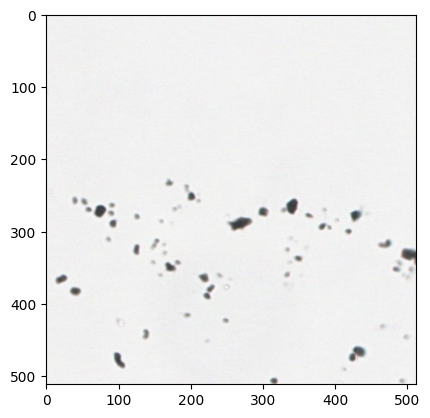

In [ ]:
plt.imshow(t_dict['backward_input'](train_dataset[0][0]))

In [ ]:
dataloader_config = {
    "batch_size": 16,
    "shuffle": True,
    "num_workers": 0
}
train_dataloader = DataLoader(train_dataset, **dataloader_config)
val_dataloader = DataLoader(val_dataset, **dataloader_config)

In [ ]:
dataloader_config = {
    "batch_size": 1,
    "shuffle": False,
    "num_workers": 0
}
test_data_hdf5 = prepare_dataset(config_test, storage_hdf5)
test_dataset_hdf5 = SegmentationDataset(test_data_hdf5, t_dict, train_flag=False)
test_dataloader = DataLoader(test_dataset_hdf5, **dataloader_config)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)
model.fc = nn.Linear(512, 2)
model.to(DEVICE)
print(model)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def compute_metrics(
    outputs: torch.Tensor,
    labels: torch.LongTensor,
):
    """
    Compute NER metrics.

    Args:
        outputs: the model outputs (batch_size, num_classes, sequence_len)
        labels: the correct classes (batch_size, sequence_len)

    Returns:
        metrics: mapping metric names to their corresponding values
    """

    metrics = {}
    y_true = None
    y_pred = None

    y_true = labels.to('cpu').detach().numpy().flatten()
    y_pred = outputs.to('cpu').detach().numpy().argmax(axis=1).flatten()

    metrics['accuracy'] = accuracy_score(
        y_true=y_true,
        y_pred=y_pred,
    )

    for metric_func in [precision_score, recall_score, f1_score]:
        metric_name = metric_func.__name__.split('_')[0]
        metrics[metric_name] = metric_func(
            y_true=y_true,
            y_pred=y_pred,
            average='macro',
            zero_division=0,
        )

    return metrics

In [ ]:
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    epoch: int,
) -> None:


    model.train()

    epoch_loss = []
    batch_metrics_list = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : []
    }


    for i, (input, labels) in tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc="loop over train batches",
    ):
        input, labels = input.to(device), labels.to(device)

        outputs = None
        loss = None

        optimizer.zero_grad()
        outputs = model(input)
        #print(outputs.shape)
        #print(label.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        epoch_loss.append(loss.item())
        writer.add_scalar(
            tag="batch loss / train",
            scalar_value=loss.item(),
            global_step=epoch * len(dataloader) + i,
        )

        with torch.no_grad():
            model.eval()

            outputs_inference = model(input)

            model.train()

        #print(outputs_inference.argmax(axis=1))
        #print(labels)
        batch_metrics = compute_metrics(
            outputs=outputs_inference,
            labels=labels,
        )

        for metric_name, metric_value in batch_metrics.items():
            batch_metrics_list[metric_name].append(metric_value)
            writer.add_scalar(
                tag=f"batch {metric_name} / train",
                scalar_value=metric_value,
                global_step=epoch * len(dataloader) + i,
            )
        #batch_metrics_list.append(metric)

        #writer.add_scalar(
        #    tag=f"batch MAE / train",
        #    scalar_value=metric,
        #    global_step=epoch * len(dataloader) + i,
        #)

    avg_loss = np.mean(epoch_loss)
    print(f"Train loss: {avg_loss}\n")
    writer.add_scalar(
        tag="loss / train",
        scalar_value=avg_loss,
        global_step=epoch,
    )

    for metric_name, metric_value_list in batch_metrics_list.items():
        metric_value = np.mean(metric_value_list)
        print(f"Train {metric_name}: {metric_value}\n")
        writer.add_scalar(
            tag=f"{metric_name} / train",
            scalar_value=metric_value,
            global_step=epoch,
        )

    #metric_value = np.mean(batch_metrics_list)
    #print(f"Train MAE: {metric_value}\n")
    #writer.add_scalar(
    #    tag=f"MAE / train",
    #    scalar_value=metric_value,
    #    global_step=epoch,
    #)

In [ ]:
def evaluate_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    epoch: int,
) -> None:

    model.eval()

    epoch_loss = []
    batch_metrics_list = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : []
    }

    with torch.no_grad():

        for i, (input, labels) in tqdm(
            enumerate(dataloader),
            total=len(dataloader),
            desc="loop over test batches",
        ):
            input, labels = input.to(device), labels.to(device)

            outputs = model(input)
            loss = criterion(outputs, labels)


            epoch_loss.append(loss.item())
            writer.add_scalar(
                tag="batch loss / test",
                scalar_value=loss.item(),
                global_step=epoch * len(dataloader) + i,
            )

            batch_metrics = compute_metrics(
                labels=labels,
                outputs=outputs,
            )

            for metric_name, metric_value in batch_metrics.items():

                batch_metrics_list[metric_name].append(metric_value)
                writer.add_scalar(
                    tag=f"batch {metric_name} / test",
                    scalar_value=metric_value,
                    global_step=epoch * len(dataloader) + i,
                )
            #batch_metrics_list.append(metric)
            #writer.add_scalar(
            #    tag=f"batch MAE / test",
            #    scalar_value=metric,
            #    global_step=epoch * len(dataloader) + i,
            #)

        avg_loss = np.mean(epoch_loss)
        print(f"Test loss:  {avg_loss}\n")
        writer.add_scalar(
            tag="loss / test",
            scalar_value=avg_loss,
            global_step=epoch,
        )


        for metric_name, metric_value_list in batch_metrics_list.items():
            metric_value = np.mean(metric_value_list)
            print(f"Test {metric_name}: {metric_value}\n")
            writer.add_scalar(
                tag=f"{metric_name} / test",
                scalar_value=np.mean(metric_value),
                global_step=epoch,
            )

        return np.mean(batch_metrics_list['f1'])
        #metric_value = np.mean(batch_metrics_list)
        #print(f"Test MAE: {metric_value}\n")
        #writer.add_scalar(
        #    tag=f"MAE / test",
        #    scalar_value=np.mean(metric_value),
        #    global_step=epoch,
        #)

In [ ]:
from torch.optim.lr_scheduler import StepLR

def train(
    n_epochs: int,
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
) -> None:

    scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
    best_f1_score = 0
    for epoch in range(n_epochs):

        print(f"Epoch [{epoch+1} / {n_epochs}]\n")
        train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            writer=writer,
            device=device,
            epoch=epoch,
        )

        cur_f1_score = evaluate_epoch(
            model=model,
            dataloader=valid_dataloader,
            criterion=criterion,
            writer=writer,
            device=device,
            epoch=epoch,
        )
        scheduler.step()
        if cur_f1_score > best_f1_score:
             best_f1_score = cur_f1_score
             torch.save(model.state_dict(), "best_model.pth")



In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f"logs")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train(
    n_epochs=20,
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    writer=writer,
    device=DEVICE,
)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [1 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.2374002933290533

Train accuracy: 0.6350524475524476

Train precision: 0.44638197369840726

Train recall: 0.6094994651812834

Train f1: 0.4933970779341622



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.2947921585291624

Test accuracy: 0.88671875

Test precision: 0.8997598755411256

Test recall: 0.8854516143578643

Test f1: 0.8789484033195334

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [2 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.18714881568847525

Train accuracy: 0.7273698523698523

Train precision: 0.6207130379333177

Train recall: 0.7155234916598553

Train f1: 0.6392437308384535



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.20413653878495097

Test accuracy: 0.9056919642857143

Test precision: 0.9139276522089022

Test recall: 0.9060143849206349

Test f1: 0.8985247300681326

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [3 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.14589430548745644

Train accuracy: 0.778943278943279

Train precision: 0.684904799939765

Train recall: 0.7664309175672812

Train f1: 0.7020371591377562



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.22844521049410105

Test accuracy: 0.9017857142857143

Test precision: 0.9135597041847042

Test recall: 0.9015219155844156

Test f1: 0.893207980529962

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [4 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.13683396214749532

Train accuracy: 0.785936285936286

Train precision: 0.6855921079697305

Train recall: 0.7738011599899713

Train f1: 0.7087779997946877



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.2618951015174389

Test accuracy: 0.8934151785714286

Test precision: 0.9002755057442557

Test recall: 0.9020214160839161

Test f1: 0.8849248064246928

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [5 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.09263961080631072

Train accuracy: 0.9558566433566433

Train precision: 0.957169394319744

Train recall: 0.9595354625949031

Train f1: 0.9532036075196879



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.0517411925829947

Test accuracy: 0.9921875

Test precision: 0.9920634920634921

Test recall: 0.9920634920634921

Test f1: 0.9920634920634921

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [6 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.09619537270074333

Train accuracy: 0.8772824397824398

Train precision: 0.824138740047831

Train recall: 0.8746014086923178

Train f1: 0.8385032519264838



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.05977240245556459

Test accuracy: 0.984375

Test precision: 0.98125

Test recall: 0.9873798076923077

Test f1: 0.9816468253968254

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [7 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.09495275745402787

Train accuracy: 0.9361888111888111

Train precision: 0.9198203796980021

Train recall: 0.9389129809584355

Train f1: 0.9230549074205053



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.06286839432141278

Test accuracy: 0.96875

Test precision: 0.9698679792429793

Test recall: 0.9671976461038961

Test f1: 0.9656724630718438

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [8 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.07269974999533563

Train accuracy: 0.9629467754467754

Train precision: 0.9681288311533068

Train recall: 0.964862497642218

Train f1: 0.9598808544106832



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.13257072406850057

Test accuracy: 0.94140625

Test precision: 0.9491184163059163

Test recall: 0.9435515873015874

Test f1: 0.9384782679947743

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [9 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.07004133121670594

Train accuracy: 0.9562937062937062

Train precision: 0.9562407386708086

Train recall: 0.9590941983424501

Train f1: 0.9536460734903097



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.027965232700807974

Test accuracy: 0.9921875

Test precision: 0.99296875

Test recall: 0.9920634920634921

Test f1: 0.9920298483765977

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [10 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.07755105208664143

Train accuracy: 0.8631993006993007

Train precision: 0.8103428768201496

Train recall: 0.8564720244790175

Train f1: 0.8168138528127731



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.06761202786583453

Test accuracy: 0.9877232142857143

Test precision: 0.9872023809523809

Test recall: 0.9877840909090909

Test f1: 0.9865054536107167

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [11 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.05919186565438871

Train accuracy: 0.9814005439005439

Train precision: 0.9794941266969239

Train recall: 0.9823758797535024

Train f1: 0.978890364362828



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.03469922687509097

Test accuracy: 0.9921875

Test precision: 0.9916666666666667

Test recall: 0.9926948051948052

Test f1: 0.9916224126750443

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [12 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.047249615469205

Train accuracy: 0.986013986013986

Train precision: 0.9855428662246843

Train recall: 0.9856886411956343

Train f1: 0.9845456056830307



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.024326156126335263

Test accuracy: 0.9921875

Test precision: 0.9916666666666667

Test recall: 0.9926948051948052

Test f1: 0.9916224126750443

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [13 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.04764239097639293

Train accuracy: 0.9820804195804196

Train precision: 0.9810755774916615

Train recall: 0.9827598780395983

Train f1: 0.9803045833069545



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.020605562371201813

Test accuracy: 0.99609375

Test precision: 0.99609375

Test recall: 0.9965277777777778

Test f1: 0.996078431372549

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [14 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.045599734620679615

Train accuracy: 0.9838286713286714

Train precision: 0.9836171404353223

Train recall: 0.9839214689739166

Train f1: 0.982602020860782



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.019399209588300437

Test accuracy: 0.9921875

Test precision: 0.9887152777777778

Test recall: 0.9936899038461539

Test f1: 0.9903641456582633

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [15 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.0525705527572834

Train accuracy: 0.9838286713286714

Train precision: 0.9833343424252514

Train recall: 0.9846525560686401

Train f1: 0.9825877001891102



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.02750851068412885

Test accuracy: 0.9921875

Test precision: 0.9936868686868687

Test recall: 0.9908854166666667

Test f1: 0.9917494270435447

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [16 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.04596598114219162

Train accuracy: 0.9843628593628594

Train precision: 0.9840195158376976

Train recall: 0.9847471584359698

Train f1: 0.9830769125935206



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.01717104806448333

Test accuracy: 0.99609375

Test precision: 0.9965277777777778

Test recall: 0.99609375

Test f1: 0.996078431372549

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [17 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.041693714464415464

Train accuracy: 0.9855769230769231

Train precision: 0.9857787414605597

Train recall: 0.9857359811905266

Train f1: 0.984637841421736



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.013758172281086445

Test accuracy: 1.0

Test precision: 1.0

Test recall: 1.0

Test f1: 1.0

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [18 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.040990753584521845

Train accuracy: 0.9851398601398601

Train precision: 0.9841250920796377

Train recall: 0.986066720769518

Train f1: 0.9837198274185484



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.01135660961153917

Test accuracy: 1.0

Test precision: 1.0

Test recall: 1.0

Test f1: 1.0

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [19 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.04015525974906408

Train accuracy: 0.9838286713286714

Train precision: 0.9830900160445617

Train recall: 0.9850682146136692

Train f1: 0.9825123275638034



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.0508870953854057

Test accuracy: 0.9681919642857143

Test precision: 0.9709096459096459

Test recall: 0.9663690476190476

Test f1: 0.9658537666538828

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [20 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.04623147424382086

Train accuracy: 0.9777097902097902

Train precision: 0.9780462835532767

Train recall: 0.9794229372026576

Train f1: 0.9763451446332935



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.05087676702532917

Test accuracy: 0.99609375

Test precision: 0.99609375

Test recall: 0.9965277777777778

Test f1: 0.996078431372549

Adjusting learning rate of group 0 to 1.0000e-05.


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [ ]:
evaluate_epoch(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion,
    writer=writer,
    device=DEVICE,
    epoch=1,
)

loop over test batches:   0%|          | 0/988 [00:00<?, ?it/s]

Test loss:  0.1781604675971103

Test accuracy: 0.9261133603238867

Test precision: 0.9261133603238867

Test recall: 0.9261133603238867

Test f1: 0.9261133603238867



0.9261133603238867

In [ ]:
def process_batches(dataloader):
    model.eval()

    true = []
    pred = []
    with torch.no_grad():
        for i, (inputs, labels) in tqdm(
                enumerate(dataloader),
                total=len(dataloader),
            ):
            outputs = model(inputs).argmax(1).cpu().numpy()
            true.extend(labels.numpy())
            pred.extend(outputs)
    return  true, pred

In [ ]:
def errors(trues, preds, dataset):
    trues = trues
    preds = preds
    idxs = np.where(np.not_equal(trues, preds))[0]
    fig, axs = plt.subplots(len(idxs))
    fig.set_figheight(100)
    fig.set_figwidth(100)
    for i, idx in enumerate(idxs):
        axs[i].imshow(t_dict['backward_input'](dataset[idx][0]))
        axs[i].set_title(f"predicted CLASS: {preds[idx]}, true CLASS: {trues[idx]}")
    fig.tight_layout()
    #plt.show()

  0%|          | 0/988 [00:00<?, ?it/s]

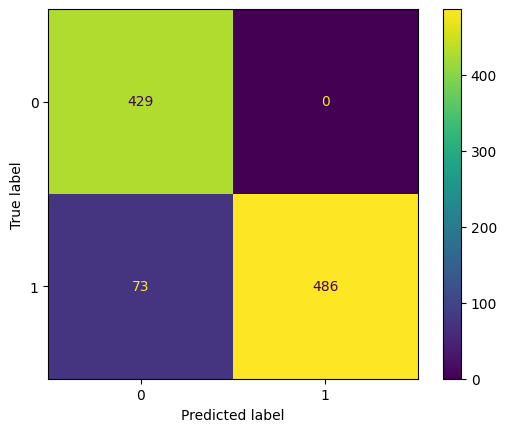

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def print_confusion_matrix(true, pred):
    disp = ConfusionMatrixDisplay(confusion_matrix(true, pred))
    disp.plot()
    plt.show()
trues, preds = process_batches(test_dataloader)
print_confusion_matrix(trues, preds)

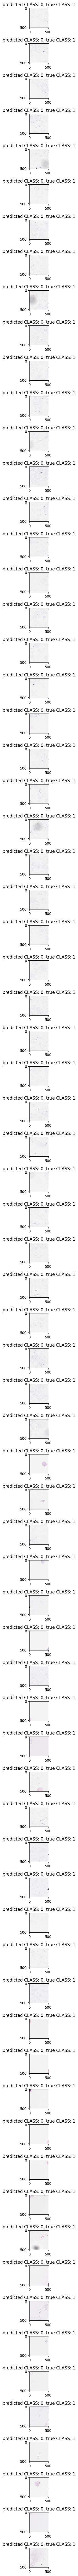

In [ ]:
errors(trues, preds, test_dataloader.dataset)